# Cell 1: Markdown
"""
# FAISS Performance Benchmarks

Comprehensive performance analysis:
1. Search latency comparison
2. Index build time
3. Memory usage
4. Accuracy vs. speed tradeoffs
5. Scalability analysis
"""

# Cell 2: Setup

In [17]:
import sys
sys.path.append('..')

import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict

from src.data_loader import DocumentationLoader
from src.embedding_engine import EmbeddingEngine
from src.vector_store import FAISSVectorStore

print("✓ All imports successful")


✓ All imports successful


# Cell 3: Load data

In [18]:
print("Loading documents and generating embeddings...")

loader = DocumentationLoader()
docs = loader.load_documents()

embedder = EmbeddingEngine()
embeddings = embedder.embed_documents(docs, text_field="text")

index_types = ["FlatIP", "IVFFlat", "HNSW"]

print(f"✓ Loaded {len(docs)} documents")
print(f"✓ Embeddings shape: {embeddings.shape}")



Loading documents and generating embeddings...
✓ Loaded 15 documents from data\processed\sample_docs.json
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
✓ Model loaded. Embedding dimension: 384
Encoding 15 documents...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Loaded 15 documents
✓ Embeddings shape: (15, 384)


# Cell 4: Benchmark 1 - Index Build Time


BENCHMARK 1: Index Build Time

Building FlatIP...

Initializing FAISS Index: FlatIP
✓ Created IndexFlatIP (exact search, cosine similarity)

Adding 15 vectors to index...
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15
  Build time: 0.000 seconds

Building IVFFlat...

Initializing FAISS Index: IVFFlat
✓ Created IndexIVFFlat
  - nlist (clusters): 10
  - Requires training before use

Adding 15 vectors to index...
Training IVFFlat index on 15 vectors...
✓ Index trained successfully
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15
  Build time: 0.001 seconds

Building HNSW...

Initializing FAISS Index: HNSW
✓ Created IndexHNSWFlat (fast approximate search)
  efConstruction: 40, efSearch: 16

Adding 15 vectors to index...
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15
  Build time: 0.000 seconds


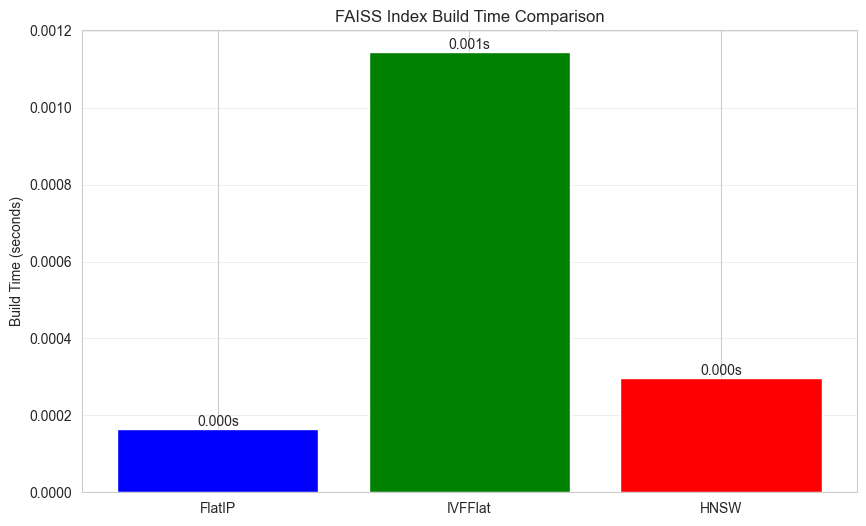

In [19]:
print("\n" + "="*60)
print("BENCHMARK 1: Index Build Time")
print("="*60)

build_times = {}

for idx_type in index_types:
    print(f"\nBuilding {idx_type}...")
    
    start = time.time()
    store = FAISSVectorStore(embedding_dim=384, index_type=idx_type)
    store.add_documents(embeddings, docs)
    elapsed = time.time() - start
    
    build_times[idx_type] = elapsed
    print(f"  Build time: {elapsed:.3f} seconds")

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(build_times.keys(), build_times.values(), color=['blue', 'green', 'red'])
plt.ylabel('Build Time (seconds)')
plt.title('FAISS Index Build Time Comparison')
plt.grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(build_times.items()):
    plt.text(i, v, f'{v:.3f}s', ha='center', va='bottom')
plt.show()



# Cell 5: Visualize build times

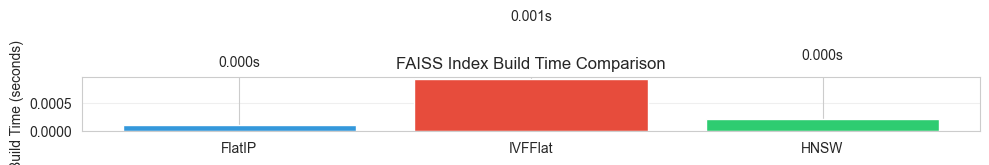

In [11]:
plt.figure(figsize=(10, 5))
plt.bar(build_times.keys(), build_times.values(), color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Build Time (seconds)')
plt.title('FAISS Index Build Time Comparison')
plt.grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(build_times.items()):
    plt.text(i, v + 0.001, f'{v:.3f}s', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Cell 6: Benchmark 2 - Search Latency

In [20]:
print("\n" + "="*60)
print("BENCHMARK 2: Search Latency")
print("="*60)

# Create indices
stores = {}
for idx_type in index_types:
    store = FAISSVectorStore(embedding_dim=384, index_type=idx_type)
    store.add_documents(embeddings, docs)
    stores[idx_type] = store

# Generate test queries
n_test_queries = 50
test_query_texts = [
    "Azure serverless computing",
    "Python data structures",
    "Machine learning services",
    "Cloud storage solutions",
    "Async programming patterns"
] * 10

test_query_embeddings = embedder.embed(test_query_texts, show_progress=False)

# Run searches with timing
search_times = defaultdict(list)

for idx_type, store in stores.items():
    print(f"\nTesting {idx_type}...")
    for q_emb in test_query_embeddings:
        # Time the search manually
        start = time.time()
        store.search(q_emb.reshape(1, -1), k=5, nprobe=3 if idx_type == "IVFFlat" else None)
        search_time_ms = (time.time() - start) * 1000
        search_times[idx_type].append(search_time_ms)

print("\n✓ Latency benchmark complete")



BENCHMARK 2: Search Latency

Initializing FAISS Index: FlatIP
✓ Created IndexFlatIP (exact search, cosine similarity)

Adding 15 vectors to index...
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15

Initializing FAISS Index: IVFFlat
✓ Created IndexIVFFlat
  - nlist (clusters): 10
  - Requires training before use

Adding 15 vectors to index...
Training IVFFlat index on 15 vectors...
✓ Index trained successfully
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15

Initializing FAISS Index: HNSW
✓ Created IndexHNSWFlat (fast approximate search)
  efConstruction: 40, efSearch: 16

Adding 15 vectors to index...
✓ Added 15 vectors in 0.00 seconds
✓ Total vectors in index: 15

Testing FlatIP...

Testing IVFFlat...

Testing HNSW...

✓ Latency benchmark complete


# Cell 7: Visualize search latency


--- Search Latency Statistics ---

FlatIP:
  Mean:   0.0093 ms
  Median: 0.0067 ms
  Std:    0.0165 ms
  Min:    0.0060 ms
  Max:    0.1245 ms
  P95:    0.0088 ms

IVFFlat:
  Mean:   0.0082 ms
  Median: 0.0050 ms
  Std:    0.0122 ms
  Min:    0.0045 ms
  Max:    0.0772 ms
  P95:    0.0226 ms

HNSW:
  Mean:   0.0052 ms
  Median: 0.0045 ms
  Std:    0.0033 ms
  Min:    0.0041 ms
  Max:    0.0279 ms
  P95:    0.0069 ms


C:\Users\sreet\AppData\Local\Temp\ipykernel_62408\1837069244.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(box_data, labels=index_types)


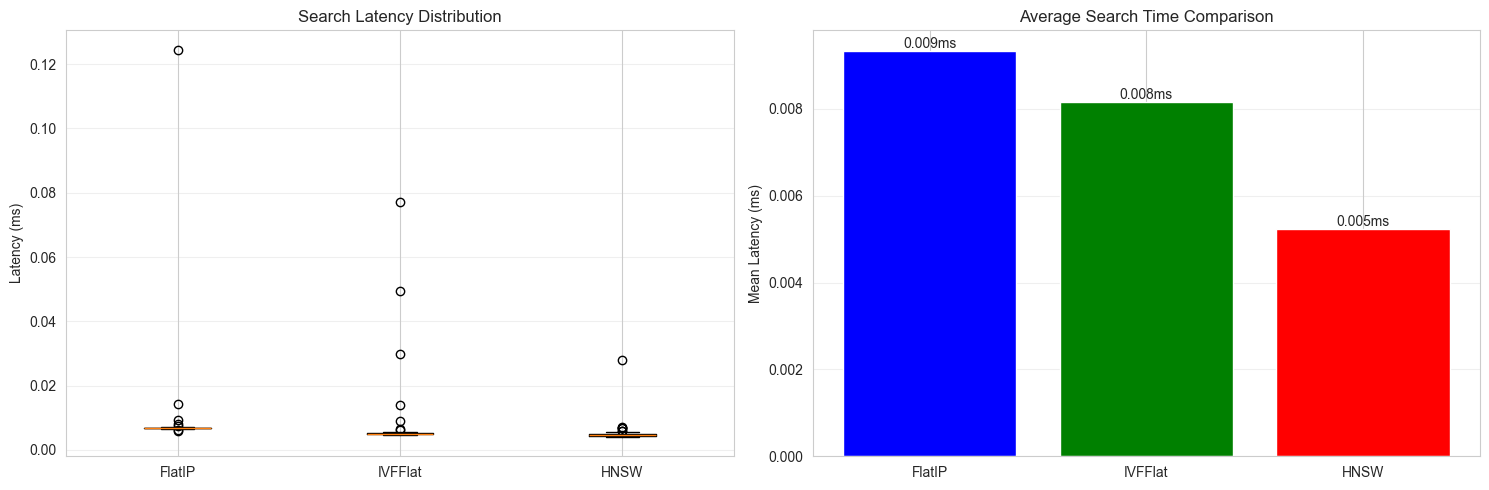

In [23]:
print("\n--- Search Latency Statistics ---")
for idx_type in index_types:
    times = search_times[idx_type]
    print(f"\n{idx_type}:")
    print(f"  Mean:   {np.mean(times):.4f} ms")
    print(f"  Median: {np.median(times):.4f} ms")
    print(f"  Std:    {np.std(times):.4f} ms")
    print(f"  Min:    {np.min(times):.4f} ms")
    print(f"  Max:    {np.max(times):.4f} ms")
    print(f"  P95:    {np.percentile(times, 95):.4f} ms")


# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
box_data = [search_times[idx] for idx in index_types]
ax1.boxplot(box_data, labels=index_types)
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Search Latency Distribution')
ax1.grid(axis='y', alpha=0.3)

# Bar chart of means
means = [np.mean(search_times[idx]) for idx in index_types]
colors = ['blue', 'green', 'red']
ax2.bar(index_types, means, color=colors)
ax2.set_ylabel('Mean Latency (ms)')
ax2.set_title('Average Search Time Comparison')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (idx, mean) in enumerate(zip(index_types, means)):
    ax2.text(i, mean, f'{mean:.3f}ms', ha='center', va='bottom')

plt.tight_layout()
plt.show()



# Cell 8: Print statistics

In [24]:
print("\n--- Search Latency Statistics ---")
for idx_type in index_types:
    times = search_times[idx_type]
    print(f"\n{idx_type}:")
    print(f"  Mean:   {np.mean(times):.4f} ms")
    print(f"  Median: {np.median(times):.4f} ms")
    print(f"  Std:    {np.std(times):.4f} ms")
    print(f"  Min:    {np.min(times):.4f} ms")
    print(f"  Max:    {np.max(times):.4f} ms")
    print(f"  P95:    {np.percentile(times, 95):.4f} ms")



--- Search Latency Statistics ---

FlatIP:
  Mean:   0.0093 ms
  Median: 0.0067 ms
  Std:    0.0165 ms
  Min:    0.0060 ms
  Max:    0.1245 ms
  P95:    0.0088 ms

IVFFlat:
  Mean:   0.0082 ms
  Median: 0.0050 ms
  Std:    0.0122 ms
  Min:    0.0045 ms
  Max:    0.0772 ms
  P95:    0.0226 ms

HNSW:
  Mean:   0.0052 ms
  Median: 0.0045 ms
  Std:    0.0033 ms
  Min:    0.0041 ms
  Max:    0.0279 ms
  P95:    0.0069 ms


# Cell 9: Benchmark 3 - Memory Usage (Approximate)

In [25]:
print("\n" + "="*60)
print("BENCHMARK 3: Memory Usage (Approximate)")
print("="*60)

import sys

memory_usage = {}
for idx_type, store in stores.items():
    # Approximate memory of index + documents
    index_size = sys.getsizeof(store.index)  # Rough estimate
    docs_size = sys.getsizeof(store.documents)
    total_mb = (index_size + docs_size) / (1024 * 1024)
    memory_usage[idx_type] = total_mb
    print(f"{idx_type}: ~{total_mb:.2f} MB")


BENCHMARK 3: Memory Usage (Approximate)
FlatIP: ~0.00 MB
IVFFlat: ~0.00 MB
HNSW: ~0.00 MB


# Cell 10: Summary comparison table

In [26]:
print("\n" + "="*60)
print("SUMMARY COMPARISON")
print("="*60)

summary_data = []
for idx_type in index_types:
    summary_data.append({
        'Index Type': idx_type,
        'Build Time (s)': f"{build_times[idx_type]:.3f}",
        'Avg Search (ms)': f"{np.mean(search_times[idx_type]):.4f}",
        'P95 Search (ms)': f"{np.percentile(search_times[idx_type], 95):.4f}",
        'Memory (MB)': f"~{memory_usage[idx_type]:.2f}"
    })

import pandas as pd
df = pd.DataFrame(summary_data)
print(df.to_string(index=False))



SUMMARY COMPARISON
Index Type Build Time (s) Avg Search (ms) P95 Search (ms) Memory (MB)
    FlatIP          0.000          0.0093          0.0088       ~0.00
   IVFFlat          0.001          0.0082          0.0226       ~0.00
      HNSW          0.000          0.0052          0.0069       ~0.00


# Cell 11: Markdown


In [27]:
"""
## Key Takeaways

1. **IndexFlatIP**: Best accuracy, slowest for large datasets, no training needed
2. **IndexIVFFlat**: Good balance of speed and accuracy, requires training
3. **IndexHNSWFlat**: Fastest search, best for production, higher memory

**Recommendation**: 
- Use **FlatIP** for <10k vectors or when 100% accuracy is critical
- Use **IVFFlat** for 10k-1M vectors with good speed/accuracy balance
- Use **HNSW** for production systems requiring low latency (<1ms)
"""

'\n## Key Takeaways\n\n1. **IndexFlatIP**: Best accuracy, slowest for large datasets, no training needed\n2. **IndexIVFFlat**: Good balance of speed and accuracy, requires training\n3. **IndexHNSWFlat**: Fastest search, best for production, higher memory\n\n**Recommendation**: \n- Use **FlatIP** for <10k vectors or when 100% accuracy is critical\n- Use **IVFFlat** for 10k-1M vectors with good speed/accuracy balance\n- Use **HNSW** for production systems requiring low latency (<1ms)\n'

# Cell 12: Markdown


In [28]:
"""
## Benchmarking Complete! ✅

All performance metrics have been collected and analyzed.

Next steps:
- Review README.md for project documentation
- Explore optional_chromadb/ for ChromaDB comparison
- Deploy to production with chosen index type
"""

'\n## Benchmarking Complete! ✅\n\nAll performance metrics have been collected and analyzed.\n\nNext steps:\n- Review README.md for project documentation\n- Explore optional_chromadb/ for ChromaDB comparison\n- Deploy to production with chosen index type\n'